In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline

In [2]:
top_train = pd.HDFStore('data/PreparedSamples_split_85_15_training_training_top_tagging_fully_contained_top_contained.h5', 
                        mode='r')
top_valid = pd.HDFStore('data/PreparedSamples_split_85_15_validation_training_top_tagging_fully_contained_top_contained.h5', 
                        mode='r')

The list of variables in the sample:

In [3]:
top_valid['df'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303135 entries, 0 to 303134
Data columns (total 67 columns):
EventInfo_mcEventNumber                     303135 non-null int32
EventInfo_ntruthJets                        303135 non-null int32
EventInfo_nfatjets                          303135 non-null int32
EventInfo_NPV                               303135 non-null int32
EventInfo_averageInteractionsPerCrossing    303135 non-null float32
fjet_truthJet_pt                            303135 non-null float32
fjet_truthJet_eta                           303135 non-null float32
fjet_truthJet_m                             303135 non-null float32
fjet_truthJet_nthLeading                    303135 non-null int32
fjet_truth_dRmatched_particle_flavor        303135 non-null float32
fjet_truth_dRmatched_particle_dR            303135 non-null float32
fjet_dRmatched_topBChild_dR                 303135 non-null float32
fjet_dRmatched_WZChild1_dR                  303135 non-null float32
fjet_dRmatched_

## Select relevant rows and columns for training
Define a function to prepare dataset for training

In [4]:
def selectEvents(df, col, part='top'):
    sel_col_name = 'fjet_training_weight_pt_{}'.format(part)
    sel_col = df[sel_col_name] > 0
    return df[col][sel_col]

top_var_list = ['fjet_Tau32_wta', 'fjet_m', 'fjet_D2', 'fjet_Split23', 'fjet_Qw', 
                'fjet_Split12', 'fjet_Tau21_wta', 'fjet_e3', 'fjet_Tau2_wta', 'fjet_pt']

def getEvents(df, part='top', col_list=None, weight_name='fjet_training_weight_pt', forced_y=None, skip_weight_suff=False):
    # weights column to read out
    if not skip_weight_suff:
        weights_name = '{}_{}'.format(weight_name, part)
    else:
        weights_name = weight_name
    
    # select features
    if col_list:
        X_cols = col_list
    else:
        X_cols = df.columns.values
    X_selected = selectEvents(df, X_cols, part=part)
    X_selected.drop([weights_name, part], axis=1, errors='ignore', inplace=True)
    # select y
    if forced_y is None:
        y_selected = selectEvents(df, col=part, part=part)
    else:
        y_selected = pd.Series(np.ones(shape=X_selected.shape[0]), index=X_selected.index) * forced_y
    # select weights
    weights = selectEvents(df, weights_name, part)
    
    return (X_selected, y_selected, weights)

Prepare training and validation datasets for training

In [5]:
X_val, y_val, w_val = getEvents(top_valid['df'], part='top', col_list=top_var_list)
X_tra, y_tra, w_tra = getEvents(top_train['df'], part='top', col_list=top_var_list)

In [6]:
truth_pt = selectEvents(top_valid['df'], part='top', col='fjet_truthJet_pt')
w_val_test = selectEvents(top_valid['df'] , part='top', col='fjet_testing_weight_pt')

In [7]:
top_valid.close()
top_train.close()

Do actual heavy-lifting by traiing a model

In [8]:
import lightgbm as lgb

In [9]:
clf=lgb.LGBMClassifier(n_estimators=500, max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=2)

Parametrs to be added to the `.fit()` call on the classifier in the hyper-parameter tuning. These are needed:
   * to define weights in the training (`sample_weight`);
   * to set up early stopping in lightgbm training (also based on ROC AUC). This avoids overtraining and allows up to keep the number of boosting iterations free to adjust to different models (different parameter choices might lead to different model flexibility)

In [10]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_val,y_val)],
            'eval_sample_weight': [w_val],
            'eval_names': ['valid'],
            'sample_weight': w_tra,
            'verbose': 50}

## Hyper-parameter optimisation (can be skipped, as the optimal parameters have already been found)
Define the parameter set to do hyper-parameter search

In [11]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 100), 
             'min_child_weight': sp_randint(1, 500), 
             'colsample_bytree': sp_uniform(loc=0.6, scale=0.4), 
             'subsample': sp_uniform(loc=0.6, scale=0.4), 
             'reg_alpha': [0, 1e-5, 1e-3, 1e-1, 1, 5, 10],
             'reg_lambda': [0, 1e-5, 1e-3, 1e-1, 1, 5, 10]}



Set up model hyper-parameter optimisation by random search using 3-fold cross-validation (the number of folds can be adjusted by the `cv` parameter). Best parameter choice will be picked based on the average ROC AUC across CV folds

In [12]:
n_HP_points_to_test = 20

from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=param_test, 
                        n_iter=n_HP_points_to_test,
                        fit_params=fit_params,
                        scoring='roc_auc',
                        cv=3,
                        refit=True,
                        return_train_score=True,
                        random_state=314,
                        verbose=True)



Training time of a single LighGBM model on these training data is `O(1 min)` using 2 parallel threads on a 2-core machine with 2 threads/core. Thus, the full CV loop will run for `O(3*20*1 min = 1h)`

In [13]:
#gs.fit(X_tra, y_tra)

/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.930927
[100]	valid's auc: 0.932813
[150]	valid's auc: 0.933374
[200]	valid's auc: 0.93365
[250]	valid's auc: 0.933789
[300]	valid's auc: 0.93391
[350]	valid's auc: 0.933956
Early stopping, best iteration is:
[364]	valid's auc: 0.933962
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.931109
[100]	valid's auc: 0.932841
[150]	valid's auc: 0.933384
[200]	valid's auc: 0.933707
[250]	valid's auc: 0.933906
[300]	valid's auc: 0.93397
Early stopping, best iteration is:
[292]	valid's auc: 0.933994
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.931005
[100]	valid's auc: 0.932751
[150]	valid's auc: 0.933328
[200]	valid's auc: 0.933635
[250]	valid's auc: 0.933767
[300]	valid's auc: 0.933851
[350]	valid's auc: 0.933877
[400]	valid's auc: 0.933911
[450]	valid's auc: 0.933903
Early stopping, b

[50]	valid's auc: 0.928698
[100]	valid's auc: 0.931157
[150]	valid's auc: 0.932102
[200]	valid's auc: 0.932603
[250]	valid's auc: 0.932865
[300]	valid's auc: 0.933144
[350]	valid's auc: 0.9333
[400]	valid's auc: 0.933409
[450]	valid's auc: 0.933499
[500]	valid's auc: 0.933571
Did not meet early stopping. Best iteration is:
[500]	valid's auc: 0.933571
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.931155
[100]	valid's auc: 0.93293
[150]	valid's auc: 0.933453
[200]	valid's auc: 0.93361
[250]	valid's auc: 0.933678
Early stopping, best iteration is:
[237]	valid's auc: 0.933716
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.931139
[100]	valid's auc: 0.93291
[150]	valid's auc: 0.933403
[200]	valid's auc: 0.933595
[250]	valid's auc: 0.933684
Early stopping, best iteration is:
[263]	valid's auc: 0.933694
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.931103
[100]	valid's auc: 0.932935
[150]

[150]	valid's auc: 0.933167
[200]	valid's auc: 0.933432
[250]	valid's auc: 0.933583
[300]	valid's auc: 0.933652
[350]	valid's auc: 0.933718
Early stopping, best iteration is:
[350]	valid's auc: 0.933718
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.930418
[100]	valid's auc: 0.932427
[150]	valid's auc: 0.933076
[200]	valid's auc: 0.933362
[250]	valid's auc: 0.933498
[300]	valid's auc: 0.933585
[350]	valid's auc: 0.933657
[400]	valid's auc: 0.93367
Early stopping, best iteration is:
[381]	valid's auc: 0.933688
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.930352
[100]	valid's auc: 0.932435
[150]	valid's auc: 0.933041
[200]	valid's auc: 0.933216
[250]	valid's auc: 0.933335
[300]	valid's auc: 0.933435
[350]	valid's auc: 0.933487
Early stopping, best iteration is:
[362]	valid's auc: 0.933502
Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.931675
[100]	valid's auc: 0.933083
[150]	valid's

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 90.7min finished


Training until validation scores don't improve for 30 rounds.
[50]	valid's auc: 0.931904
[100]	valid's auc: 0.933539
[150]	valid's auc: 0.93406
[200]	valid's auc: 0.934344
[250]	valid's auc: 0.934493
[300]	valid's auc: 0.934613
[350]	valid's auc: 0.934682
Early stopping, best iteration is:
[351]	valid's auc: 0.934683


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, metric='None',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=2, num_leaves=31, objective=None,
        random_state=314, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1),
          fit_params={'eval_names': ['valid'], 'sample_weight': 0          0.585735
1          0.777827
2          0.548191
3          0.642576
4          0.506135
5          0.617371
6          0.549067
7          0.577313
8          0.559611
9          0.840257
10         0.946498
11         0.708390
12    ...    0.186042  7.768792e+05

[303135 rows x 10 columns], array([0, 0, ..., 1, 1]))], 'verbose': 50},
          iid=True, n_iter=20, n_jobs=1,
          param_distributions={'num_leaves': <scipy.stats._distn_in

In [14]:
#import pickle

In [16]:
#pickle.dump(gs, file=open('gs_lgb_v00.pkl', mode='wb'))

In [20]:
#gs.cv_results_['mean_train_score']

/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([0.94372454, 0.94495454, 0.94230111, 0.94056462, 0.94308357,
       0.94323192, 0.94063235, 0.94188877, 0.94356902, 0.94409139,
       0.9428202 , 0.94347603, 0.94189017, 0.94367274, 0.94256694,
       0.94272663, 0.94375597, 0.94352246, 0.94297206, 0.94367428])

In [21]:
#gs.cv_results_['mean_test_score']

array([0.94055143, 0.94085161, 0.93956597, 0.93934045, 0.94044966,
       0.93997638, 0.93931113, 0.94003497, 0.94035093, 0.94061216,
       0.94030212, 0.9405801 , 0.93992503, 0.94043586, 0.93981934,
       0.94000977, 0.94033028, 0.94033421, 0.94038146, 0.94029436])

In [23]:
#gs.best_score_

0.9408516129058941

In [24]:
#gs.best_params_

{'colsample_bytree': 0.9672004250163085,
 'min_child_weight': 443,
 'num_leaves': 92,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.9647053597566241}

## Model fitting
To same computational time, let's directly set model parameters to the optimal values determined and printed above. We will do some rounding and also set the number of boosting rounds to 250, which is roughly the point, when ROC AUC stops improving significantly based on the CV fits above.

In [13]:
clf.set_params(**{'colsample_bytree': 0.967,
 'min_child_weight': 450,
 'num_leaves': 90,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.965,
 'n_estimators': 250})

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.967, learning_rate=0.1, max_depth=-1,
        metric='None', min_child_samples=20, min_child_weight=450,
        min_split_gain=0.0, n_estimators=250, n_jobs=2, num_leaves=90,
        objective=None, random_state=314, reg_alpha=0, reg_lambda=0.1,
        silent=True, subsample=0.965, subsample_for_bin=200000,
        subsample_freq=1)

In [14]:
clf.fit(X_tra, y_tra, sample_weight=w_tra)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.967, learning_rate=0.1, max_depth=-1,
        metric='None', min_child_samples=20, min_child_weight=450,
        min_split_gain=0.0, n_estimators=250, n_jobs=2, num_leaves=90,
        objective=None, random_state=314, reg_alpha=0, reg_lambda=0.1,
        silent=True, subsample=0.965, subsample_for_bin=200000,
        subsample_freq=1)

## Feature importance

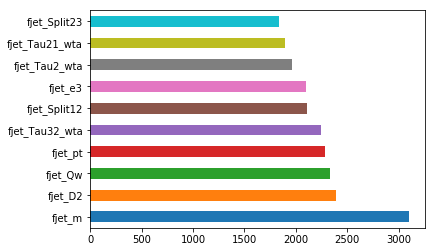

In [15]:
feat_imp = pd.Series(clf.feature_importances_, index=X_tra.columns)
feat_imp.nlargest(10).plot(kind='barh')

## Let's do a test using the same model setup for the top-3 features

In [18]:
col_top3=feat_imp.nlargest(3).index.values
print('Top3 cols: {}'.format(col_top3))
clf_top3=lgb.LGBMClassifier(**clf.get_params())
clf_top3.fit(X_tra[col_top3], y_tra, sample_weight=w_tra)

Top3 cols: ['fjet_m' 'fjet_D2' 'fjet_Qw']


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.967, learning_rate=0.1, max_depth=-1,
        metric='None', min_child_samples=20, min_child_weight=450,
        min_split_gain=0.0, n_estimators=250, n_jobs=2, num_leaves=90,
        objective=None, random_state=314, reg_alpha=0, reg_lambda=0.1,
        silent=True, subsample=0.965, subsample_for_bin=200000,
        subsample_freq=1)

In [25]:
col_top5=feat_imp.nlargest(5).index.values
print('Top5 cols: {}'.format(col_top5))
clf_top5=lgb.LGBMClassifier(**clf.get_params())
clf_top5.fit(X_tra[col_top5], y_tra, sample_weight=w_tra)

Top5 cols: ['fjet_m' 'fjet_D2' 'fjet_Qw' 'fjet_pt' 'fjet_Tau32_wta']


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.967, learning_rate=0.1, max_depth=-1,
        metric='None', min_child_samples=20, min_child_weight=450,
        min_split_gain=0.0, n_estimators=250, n_jobs=2, num_leaves=90,
        objective=None, random_state=314, reg_alpha=0, reg_lambda=0.1,
        silent=True, subsample=0.965, subsample_for_bin=200000,
        subsample_freq=1)

In [47]:
col_cus3=['fjet_Tau32_wta', 'fjet_m', 'fjet_Split23']
print('Custom3 cols: {}'.format(col_cus3))
clf_cus3=lgb.LGBMClassifier(**clf.get_params())
clf_cus3.fit(X_tra[col_cus3], y_tra, sample_weight=w_tra)

Custom3 cols: ['fjet_Tau32_wta', 'fjet_m', 'fjet_Split23']


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.967, learning_rate=0.1, max_depth=-1,
        metric='None', min_child_samples=20, min_child_weight=450,
        min_split_gain=0.0, n_estimators=250, n_jobs=2, num_leaves=90,
        objective=None, random_state=314, reg_alpha=0, reg_lambda=0.1,
        silent=True, subsample=0.965, subsample_for_bin=200000,
        subsample_freq=1)

## Model evaluation

In [20]:
from sklearn.metrics import roc_auc_score

In [21]:
roc_auc_val = roc_auc_score(y_val, clf.predict_proba(X_val)[:,1], sample_weight=w_val)

In [22]:
roc_auc_val

0.9343709040779385

In [26]:
roc_auc_val_top3 = roc_auc_score(y_val, clf_top3.predict_proba(X_val[col_top3])[:,1], sample_weight=w_val)
roc_auc_val_top5 = roc_auc_score(y_val, clf_top5.predict_proba(X_val[col_top5])[:,1], sample_weight=w_val)
print('ROC AUC: Top3 {}, Top5 {}'.format(roc_auc_val_top3, roc_auc_val_top5))

ROC AUC: Top3 0.9144029966416435, Top5 0.9269250574679545


## Plot the performance curve integrated in pT
It is kind of like the proper ROC curve, but axes are aswaped and inverse false positive rate, `FPR`, is ploted to show background rejection

In [48]:
from sklearn.metrics import roc_curve
def plotTopWROC(tpr_, fpr_):
    plotTopWROCs([(tpr_, fpr_, 'LightGBM')])
    
def plotTopWROCs(l_rocs, 
                 ylim=(1e0,1e4), xlim=(0.3, 1.0), 
                 title='ROC val sample',
                 fout_name=None):
    eps = 1e-8
    colors = ['darkorange', 'darkblue', 'darkred', 'green', 'magenta']
    style  = ['solid', 'dashed', 'dotted', 'dotted', 'dotted']
    
    fig = plt.figure(figsize=(6,6))
    lw = 2
    for i,roc in enumerate(l_rocs):
        tpr_, fpr_, lbl_ = roc
        plt.plot(tpr_+eps, 
             1./(fpr_+eps), 
             color=colors[i],
             ls=style[i],
             lw=lw, 
             label=lbl_ )
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.yscale('log')
    plt.ylabel('Background rejection')
    plt.xlabel('Signal efficiency')
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()
    if fout_name:
        fig.savefig(fout_name)

In [21]:
fpr, tpr, _ = roc_curve(y_val, clf.predict_proba(X_val)[:,1], sample_weight=w_val)

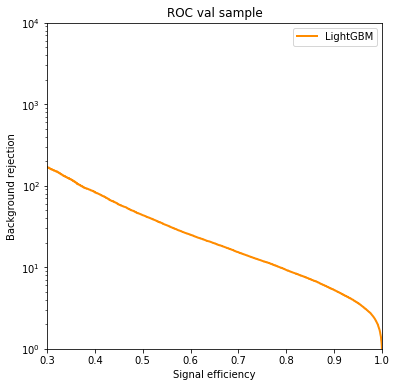

In [62]:
plotTopWROC(tpr, fpr)

## Read in and trim testing signal data

In [27]:
top_test_sig = pd.HDFStore('data/PreparedSamples__testing_Zprime.root_forTopWtag_NvarM_none.h5')

In [28]:
X_test_sg, y_test_sg, w_test_sg = getEvents(top_test_sig['df'], 
                                   part='top', 
                                   col_list=top_var_list, 
                                   weight_name='fjet_testing_weight_pt', 
                                   forced_y=1, 
                                   skip_weight_suff=True)

In [29]:
truth_pt_test_sg = selectEvents(top_test_sig['df'], part='top', col='fjet_truthJet_pt')
top_BDT_sg = selectEvents(top_test_sig['df'], part='top', col='BDT_TOP3qtag')

In [30]:
top_test_sig.close()

## Read in and trim testing background data

In [31]:
top_test_bg = pd.HDFStore('data/PreparedSamples__testing_full_jzxw.root_forTopWtag_NvarM_none.h5')

`top_test_bg` is **HUGE** (~3.5 GB). But it is loaded into memory only when you manipulate it. Memory seems to be cleared after you stop using the data

In [32]:
X_test_bg, y_test_bg, w_test_bg = getEvents(top_test_bg['df'], 
                                   part='top', 
                                   col_list=top_var_list, 
                                   weight_name='fjet_testing_weight_pt', 
                                   forced_y=0, 
                                   skip_weight_suff=True)

In [33]:
truth_pt_test_bg = selectEvents(top_test_bg['df'], part='top', col='fjet_truthJet_pt')
top_BDT_bg = selectEvents(top_test_bg['df'], part='top', col='BDT_TOP3qtag')

In [34]:
top_test_bg.close()

## Let's do comparison of performance

In [35]:
n_s=X_test_sg.shape[0]
n_b=n_s
X_test = pd.concat([X_test_sg.iloc[:n_s], X_test_bg.iloc[:n_b]])
y_test = pd.concat([y_test_sg.iloc[:n_s], y_test_bg.iloc[:n_b]])
w_test = pd.concat([w_test_sg.iloc[:n_s], w_test_bg.iloc[:n_b]])
truth_pt_test = pd.concat([truth_pt_test_sg.iloc[:n_s], truth_pt_test_bg.iloc[:n_b]])
top_BDT = pd.concat([top_BDT_sg.iloc[:n_s], top_BDT_bg.iloc[:n_b]])

The function to compare TMVA and LGBM performance

In [49]:
def plotROCInPtBin(ptmin, ptmax):
    pt_range = (truth_pt_test < ptmax) & (truth_pt_test > ptmin)
    fpr_, tpr_, _ = roc_curve(y_test[pt_range], 
                              clf.predict_proba(X_test[pt_range])[:,1], 
                              sample_weight=w_test[pt_range])
    fpr3_, tpr3_, _ = roc_curve(y_test[pt_range], 
                              clf_top3.predict_proba(X_test[col_top3][pt_range])[:,1], 
                              sample_weight=w_test[pt_range])
    fpr5_, tpr5_, _ = roc_curve(y_test[pt_range], 
                              clf_top5.predict_proba(X_test[col_top5][pt_range])[:,1], 
                              sample_weight=w_test[pt_range])
    fpr3t_, tpr3t_, _ = roc_curve(y_test[pt_range], 
                              clf_cus3.predict_proba(X_test[col_cus3][pt_range])[:,1], 
                              sample_weight=w_test[pt_range])
    fbdt_, tbdt_, _ = roc_curve(y_test[pt_range], 
                                top_BDT[pt_range], 
                                sample_weight=w_test[pt_range])
    
    iptmin=int(ptmin/1e3)
    iptmax=int(ptmax/1e3)
    plotTopWROCs([(tbdt_, fbdt_, 'TMVA (paper)'), 
                  (tpr_,  fpr_,  'LightGBM'),
                  (tpr3_,  fpr3_,  'LightGBM Top3 vars'),
                  (tpr5_,  fpr5_,  'LightGBM Top5 vars'),
                  (tpr3t_,  fpr3t_,  'LightGBM Custom3 vars')],
                 ylim=(1e0,1e3),
                 title='{} < pT < {} GeV'.format(iptmin, iptmax), 
                 fout_name='roc_{}_{}_tmp.png'.format(iptmin, iptmax))

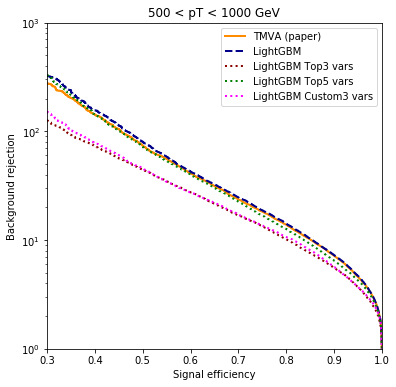

In [50]:
plotROCInPtBin(500e3, 1000e3)

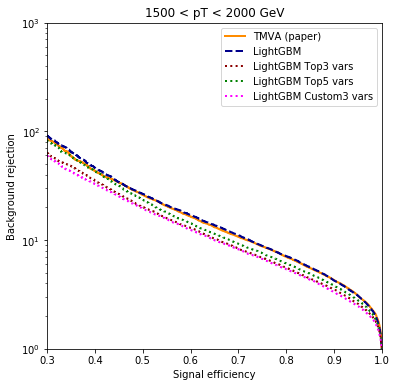

In [51]:
plotROCInPtBin(1500e3, 2000e3)